## 0. Table of Content


1. [프로젝트 소개](#1.-프로젝트-소개)  
   1.1 [프로젝트 배경](#1.1-프로젝트-배경)  
   1.2 [프로젝트 목적](#1.2-프로젝트-목적)   
2. [환경 세팅 및 데이터 업로드](#2.-환경-세팅-및-데이터-업로드)
3. [데이터 정제 및 전처리](#3.-데이터-정제-및-전처리)   
   3.1 [기초 재고 데이터](#3.1.-기초-재고-데이터)  
   3.2 [입고 재고 데이터](#3.2.-입고-재고-데이터)  
   3.3 [매출 데이터](#3.3.-매출-데이터)
5. [ABC 분석](#4.-ABC-분석)
6. [XYZ 분석](#5.-XYZ-분석)
7. [Dead Stock](#6.-Dead-Stock)
8. [Summary](#7.-Summary)

## 1. 프로젝트 소개

### 1.2 프로젝트 배경

이 프로젝트의 대상은 와인, 보드카, 위스키 등의 주류를 판매하는 소매 체인입니다.  
다양한 벤더로부터 완제품을 직접 구매하여 여러 매장에 분배하는 방식으로 운영되고 있습니다.  
제품 종류가 매우 다양하다 보니 제품별 수요 예측 및 재고 관리에 어려움이 따르고 있으며,  
이로 인해 불필요한 재고가 누적되고, 자본이 비효율적으로 묶이는 현상이 발생하고 있습니다.   
특히, 회전율이 낮은 제품들이 장기 재고로 남아 수익성 저하로 이어지는 문제가 있습니다.

### 1.3 프로젝트 목적

1) ABC 분석을 통해 제품별 수익 기여도를 파악하고, XYZ 분석을 통해 제품별 수요 변동성을 분석
2) 매장별 ABC·XYZ 결과를 기반으로 제품을 카테고리화하고, 카테고리별 맞춤형 재고 관리 전략 제안
3) 매장별 Dead Stock을 식별하여 불필요한 재고를 축소하고, 운영 효율성을 향상

## 2. 환경 세팅 및 데이터 업로드

In [123]:
#라이브러리 가져오기
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from matplotlib import style as style
import matplotlib.ticker as ticker
import os 
import numpy as np
import seaborn as sns 
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) 

In [108]:
sns.set_theme(font_scale=1.5)
sns.set_style("whitegrid")

In [170]:
font_list = fm.findSystemFonts(fontpaths=None, fontext='ttf')
font_path = f'C:\\Users\\annaz\\AppData\\Local\\Microsoft\\Windows\\Fonts\\나눔손글씨 기쁨밝음.ttf'
fontprop = fm.FontProperties(fname=font_path, size=20)
plt.rc("font", family=fontprop.get_name())

In [171]:
style.use("fivethirtyeight")

In [5]:
os.getcwd()
os.chdir(r"C:\Users\annaz\OneDrive\문서\GitHub\Inventory Optimization\warehouse-inventory-optimization\data\cleaned_data")
os.listdir()

['cleaned_endinv.csv',
 'cleaned_invoices.csv',
 'cleaned_productprice.csv',
 'cleaned_purchases.csv',
 'cleaned_sales.csv',
 'cleaned_srtinv.csv',
 'data_for_viz.csv',
 'dead_stock.csv']

In [6]:
# 기초 재고 데이터셋 불러오기
srtinv = pd.read_csv(
    'cleaned_srtinv.csv',
    dtype={'Store': 'str', 'Brand': 'str'},
    parse_dates=['startDate']
)

# 기말 재고 데이터셋 불러오기
endinv = pd.read_csv(
    'cleaned_endinv.csv',
    dtype={'Store': 'str', 'Brand': 'str'},
    parse_dates=['endDate']
)

# 공급업체로부터 제품 매입 기록 데이터셋 불러오기
purchases = pd.read_csv(
    'cleaned_purchases.csv',
    dtype={'Brand': 'str', 'Store': 'str', 'VendorNumber': 'str', 'PONumber': 'str'},
    parse_dates=['PODate', 'ReceivingDate', 'InvoiceDate', 'PayDate']
)

# 매출 데이터셋 불러오기
sales = pd.read_csv(
    'cleaned_sales.csv',
    dtype={'Brand': 'str', 'Store': 'str', 'VendorNo': 'str'},
    parse_dates=['SalesDate']
)

> 이 프로젝트에 사용하는 데이터셋은 앞서 클리닝된 데이터이므로 바로 사용 가능합니다.  
> 링크

In [7]:
dataframes = [srtinv, endinv, purchases, sales]

for df in dataframes: 
    df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 206529 entries, 0 to 206528
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InventoryId  206529 non-null  object        
 1   Store        206529 non-null  object        
 2   City         206529 non-null  object        
 3   Brand        206529 non-null  object        
 4   Description  206529 non-null  object        
 5   Size         206529 non-null  object        
 6   onHand       206529 non-null  int64         
 7   Price        206529 non-null  float64       
 8   startDate    206529 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(1), object(6)
memory usage: 14.2+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 224489 entries, 0 to 224488
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InventoryId  224489 non-null  object       

## 3. 데이터 정제 및 전처리

> ABC 분석을 수익 기준으로 진행할 계획입니다.  
> 현재 데이터셋에는  수익 값이 없으므로, 먼저 `Purchases` 데이터와 `srtinv` 데이터를 통합하여 지난 1년간 재고 제품의 매입가를 정리합니다.  
> 이후 이를 `Sales` 데이터와 병합하여, 각 제품의 수익률(판매가 대비 원가 비율)을 계산합니다.

### 3.1. 기초 재고 데이터

In [8]:
srtinv.head()

,InventoryId,Store,City,Brand,Description,Size,onHand,Price,startDate
0,1_HARDERSFIELD_58,1,HARDERSFIELD,58,Gekkeikan Black & Gold Sake,750mL,8,12.99,2016-01-01
1,1_HARDERSFIELD_60,1,HARDERSFIELD,60,Canadian Club 1858 VAP,750mL,7,10.99,2016-01-01
2,1_HARDERSFIELD_62,1,HARDERSFIELD,62,Herradura Silver Tequila,750mL,6,36.99,2016-01-01
3,1_HARDERSFIELD_63,1,HARDERSFIELD,63,Herradura Reposado Tequila,750mL,3,38.99,2016-01-01
4,1_HARDERSFIELD_72,1,HARDERSFIELD,72,No. 3 London Dry Gin,750mL,6,34.99,2016-01-01


Text(0.7, 21.99, 'Q3: 21.99')

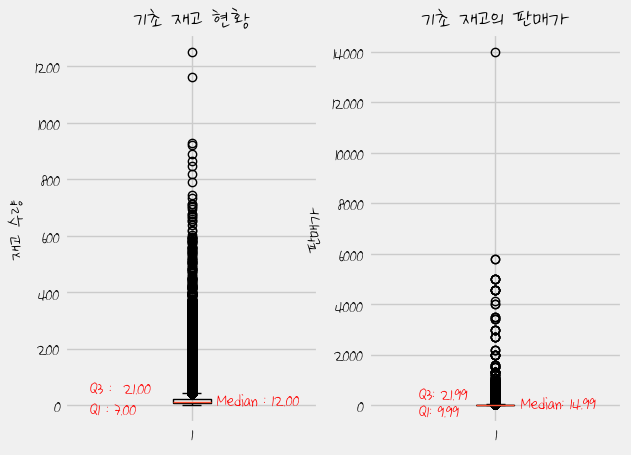

In [9]:
fig, axs = plt.subplots(1,2)

axs[0].boxplot(srtinv.onHand)
axs[0].set_title("기초 재고 현황")
axs[0].set_ylabel('재고 수량')

q1 = np.percentile(srtinv.onHand, 25)
median = np.median(srtinv.onHand)
q3 = np.percentile(srtinv.onHand, 75)

axs[0].text(1.1, median, f'Median : {median:.2f}', va = 'center', color = 'r')
axs[0].text(0.6, q1, f'Q1 : {q1:.2f}', va = 'top', color = 'r')
axs[0].text(0.6, q3, f'Q3 : {q3: .2f}', va = 'bottom', color = 'r')


axs[1].boxplot(srtinv.Price)
axs[1].set_title("기초 재고의 판매가")
axs[1].set_ylabel('판매가')

q1_p = np.percentile(srtinv.Price, 25)
median_p = np.median(srtinv.Price)
q3_p = np.percentile(srtinv.Price, 75)

axs[1].text(1.1, median_p, f'Median: {median_p:.2f}', va = 'center', color = 'r')
axs[1].text(0.7, q1_p, f'Q1: {q1_p:.2f}', va = 'top', color = 'r')
axs[1].text(0.7, q3_p, f'Q3: {q3_p:.2f}', va = 'bottom', color = 'r')


> 기초 재고는 대부분 한 매장에서 제품별 7~21개 수준으로 나타납니다.  
> 일부 제품은 특정 매장에서 재고가 과도하게 쌓여 있는 것으로 보입니다.  
> 제품 판매가의 중앙값은 15달러 미만이지만, 이상치가 존재합니다.  
> 해당 고가 제품에 대해서는 별도의 확인이 필요합니다. (추후 ABC 및 XYZ 분류 결과를 통해 확인 예정)  

In [10]:
#이상치 계산

def outliers (df, column):
    q1 = np.percentile(srtinv[column], 25)
    q3 = np.percentile(srtinv[column], 75)
    iqr = (q3 - q1) *1.5

    outliers = df[(df[column] >= (q3 + iqr)) | (df[column] <= (q1 - iqr))]

    return outliers

In [11]:
srtinv_price_outliers = outliers (srtinv, 'Price')
srtinv_onHand_outliers = outliers (srtinv, 'onHand')

[Text(0, 0, 'Grey Goose Vodka'),
 Text(0, 0, 'Smirnoff 80 Proof'),
 Text(0, 0, 'Smirnoff 80 Proof'),
 Text(0, 0, 'Smirnoff Watermelon'),
 Text(0, 0, 'Jack Daniels No 7 Black')]

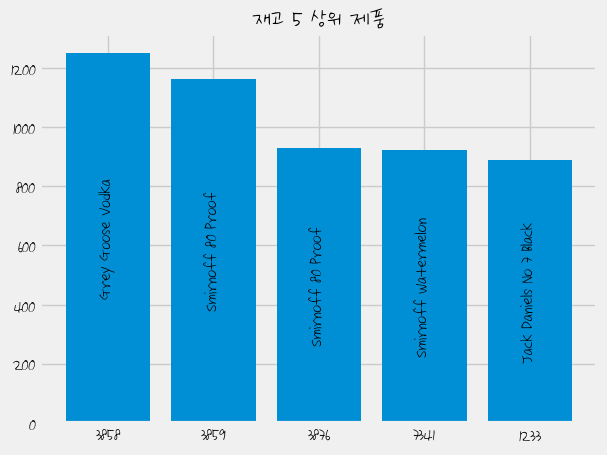

In [12]:
top_5 = srtinv.sort_values(by = 'onHand', ascending = False).head(5)
fig, ax = plt.subplots()
bar_container = ax.bar(top_5.Brand, top_5.onHand)
ax.set(title = '재고 5 상위 제품')
ax.bar_label(bar_container, labels=top_5.Description,
             rotation=90,
             label_type='center')

Text(0, 0.5, '매장별 합계 수량')

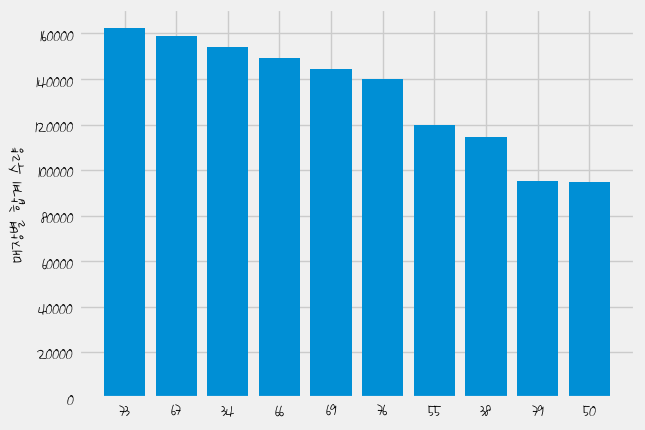

In [13]:
store_grouped = srtinv.groupby('Store')['onHand'].sum().reset_index()\
    .sort_values(by = 'onHand', ascending = False).head(10)
plt.bar(store_grouped['Store'], store_grouped['onHand'])
plt.ylabel('매장별 합계 수량')

[Text(0, 0, 'Capt Morgan Spiced Rum'),
 Text(0, 0, 'Absolut 80 Proof'),
 Text(0, 0, 'Smirnoff 80 Proof'),
 Text(0, 0, 'Ketel One Vodka'),
 Text(0, 0, "Maurice's Mentholated Mint"),
 Text(0, 0, 'Grey Goose Vodka'),
 Text(0, 0, 'Smirnoff 80 Proof'),
 Text(0, 0, 'Jack Daniels No 7 Black'),
 Text(0, 0, 'Bacardi Superior Rum'),
 Text(0, 0, 'Kendall Jackson Chard Vt RSV')]

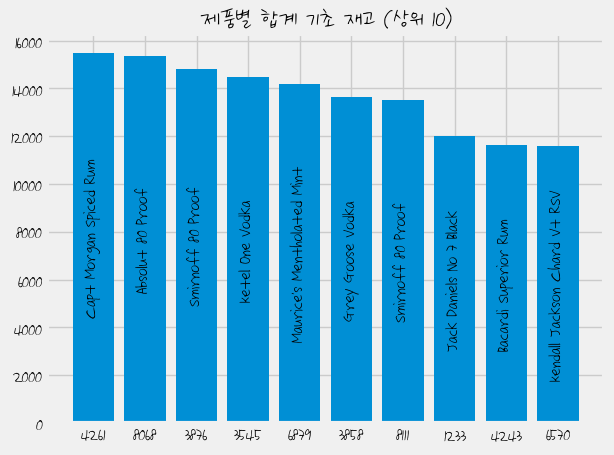

In [14]:
brand_grouped = srtinv.groupby('Brand').agg({'onHand': 'sum', 'Description':'first'})\
    .reset_index()\
    .sort_values(by = 'onHand', ascending = False).head(10)
fig, ax = plt.subplots()
bar_container = ax.bar(brand_grouped.Brand, brand_grouped.onHand)
ax.set(title = '제품별 합계 기초 재고 (상위 10)')
ax.bar_label(bar_container, labels=brand_grouped.Description,
             rotation=90,
             label_type='center')

> 기초 재고 데이터셋에서 필요한 열(Brand, Description, onHand)을 추출하고,  
> `onHand` 컬럼명을 `Quantity`로 변경  
> 수량이 0인 제품은 제외  
> Brand와 Description 기준으로 그룹화하여 총 수량(Quantity) 합계를 계산

In [15]:
start_stock = srtinv[['Brand', 'Description', 'onHand']]
start_stock = start_stock.rename(columns = {'onHand' : 'Quantity'})
start_stock = start_stock[start_stock['Quantity'] != 0].copy()
start_stock_grouped = start_stock.groupby(['Brand', 'Description']).agg({'Quantity' : 'sum'}).reset_index()

In [16]:
start_stock_grouped.sort_values(by = 'Quantity', ascending = False)

,Brand,Description,Quantity
6106,4261,Capt Morgan Spiced Rum,15499
7532,8068,Absolut 80 Proof,15341
5616,3876,Smirnoff 80 Proof,14829
5116,3545,Ketel One Vodka,14499
7324,6879,Maurice's Mentholated Mint,14180
...,...,...,...
6069,42333,Borgo M Fruili Pnt Grigio,1
1987,19768,B & G CDP Rose,1
7183,6389,Carlo Rossi Blush Calif,1
7085,6063,Avion Espresso,1


### 3.2. 입고 재고 데이터

In [17]:
purchases.head()

,InventoryId,Store,Brand,Description,Size,VendorNumber,VendorName,PONumber,PODate,ReceivingDate,InvoiceDate,PayDate,PurchasePrice,Quantity,Dollars,Classification
0,69_MOUNTMEND_8412,69,8412,Tequila Ocho Plata Fresno,750mL,105,ALTAMAR BRANDS LLC,8124,2015-12-21,2016-01-02,2016-01-04,2016-02-16,35.71,6,214.26,1
1,30_CULCHETH_5255,30,5255,TGI Fridays Ultimte Mudslide,1.75L,4466,AMERICAN VINTAGE BEVERAGE,8137,2015-12-22,2016-01-01,2016-01-07,2016-02-21,9.35,4,37.40,1
2,34_PITMERDEN_5215,34,5215,TGI Fridays Long Island Iced,1.75L,4466,AMERICAN VINTAGE BEVERAGE,8137,2015-12-22,2016-01-02,2016-01-07,2016-02-21,9.41,5,47.05,1
3,1_HARDERSFIELD_5255,1,5255,TGI Fridays Ultimte Mudslide,1.75L,4466,AMERICAN VINTAGE BEVERAGE,8137,2015-12-22,2016-01-01,2016-01-07,2016-02-21,9.35,6,56.10,1
4,76_DONCASTER_2034,76,2034,Glendalough Double Barrel,750mL,388,ATLANTIC IMPORTING COMPANY,8169,2015-12-24,2016-01-02,2016-01-09,2016-02-16,21.32,5,106.60,1


Text(0, 0.5, '매입된 수량')

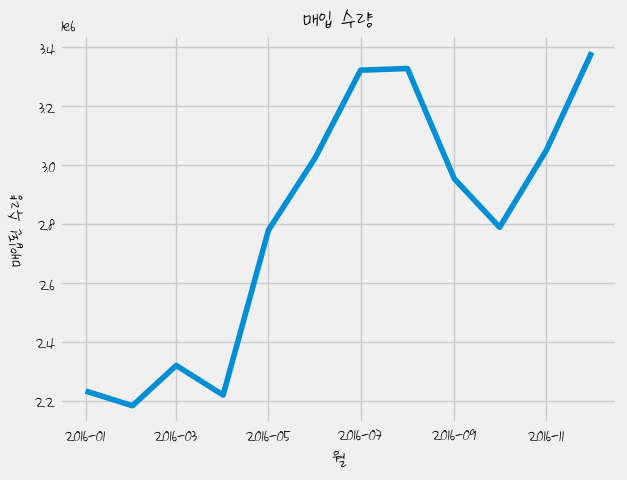

In [18]:
purchases['PurchasesMonth'] = purchases.ReceivingDate.dt.to_period('M')
purc_group_month = purchases.groupby('PurchasesMonth')['Quantity'].sum().reset_index()
purc_group_month['PurchasesMonth'] = purc_group_month['PurchasesMonth'].dt.to_timestamp()
plt.plot(purc_group_month.PurchasesMonth, purc_group_month.Quantity)
plt.title('매입 수량')
plt.xlabel('월')
plt.ylabel('매입된 수량')

Text(0.7, 5681.81, 'max: 5681.81')

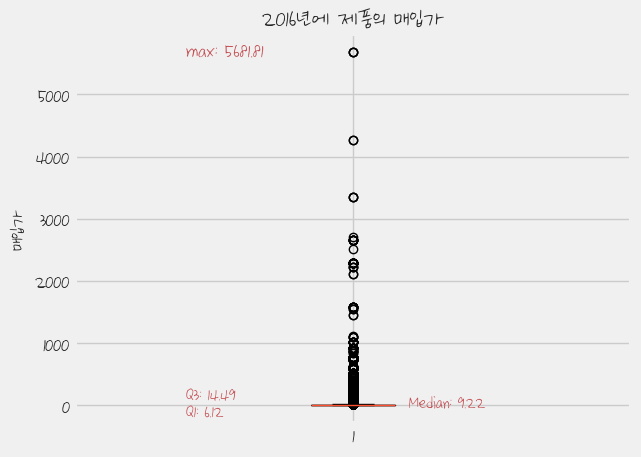

In [210]:
fig, axs = plt.subplots()

axs.boxplot(purchases.PurchasePrice)
axs.set_title("2016년에 제품의 매입가")
axs.set_ylabel('매입가')

q1_p = np.percentile(purchases.PurchasePrice, 25)
median_p = np.median(purchases.PurchasePrice)
q3_p = np.percentile(purchases.PurchasePrice, 75)
max_p = np.max(purchases.PurchasePrice)

axs.text(1.1, median_p, f'Median: {median_p:.2f}', va = 'center', color = 'r')
axs.text(0.7, q1_p, f'Q1: {q1_p:.2f}', va = 'top', color = 'r')
axs.text(0.7, q3_p, f'Q3: {q3_p:.2f}', va = 'bottom', color = 'r')
axs.text(0.7, max_p, f'max: {max_p:.2f}', va = 'center', color = 'r', fontsize = 17)

[Text(0, 0, 'Smirnoff 80 Proof'),
 Text(0, 0, 'Yukon Jack'),
 Text(0, 0, "Dr McGillicuddy's Mentholmnt"),
 Text(0, 0, 'Smirnoff Raspberry Vodka'),
 Text(0, 0, 'Kendall Jackson Chard Vt RSV'),
 Text(0, 0, 'Capt Morgan Spiced Rum'),
 Text(0, 0, 'Absolut 80 Proof'),
 Text(0, 0, "Tito's Handmade Vodka"),
 Text(0, 0, 'Skyy Vodka'),
 Text(0, 0, 'Smirnoff Traveler')]

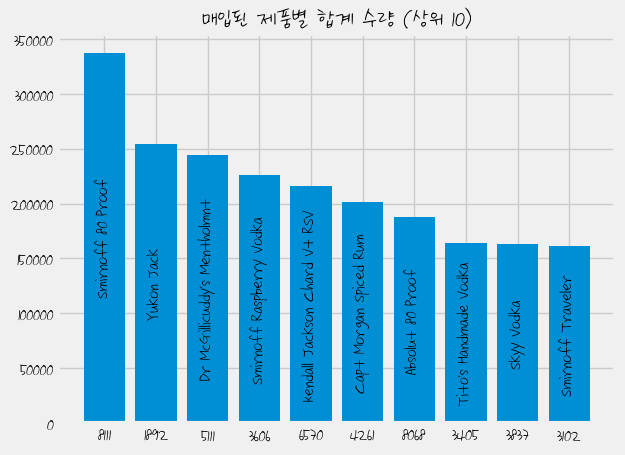

In [20]:
purc_brand_grouped = purchases.groupby('Brand')\
                .agg({'Quantity': 'sum',
                      'Description':'first'})\
    .reset_index().sort_values(by = 'Quantity', ascending =False).head(10)

fig, ax = plt.subplots()
bar_container = ax.bar(purc_brand_grouped.Brand, purc_brand_grouped.Quantity)
ax.set(title = '매입된 제품별 합계 수량 (상위 10)')
ax.bar_label(bar_container, labels=purc_brand_grouped.Description,
             rotation=90,
             label_type='center')

> 가장 많이 매입한 제품의 ABC 및 XYZ 카테고리를 확인할 필요가 있습니다.

> 구매 데이터(purchases)에서 분석에 필요한 열(Brand, Description, PurchasePrice, Quantity)만 추출

In [21]:
year_stock = purchases[['Brand', 'Description', 'PurchasePrice', 'Quantity']]

In [22]:
pd.set_option('display.max_rows', 153)
year_stock[year_stock['PurchasePrice']==0]

,Brand,Description,PurchasePrice,Quantity
1369009,2166,The Macallan Double Cask 12,0.0,12
1369018,2166,The Macallan Double Cask 12,0.0,12
1369031,2166,The Macallan Double Cask 12,0.0,12
1369032,2166,The Macallan Double Cask 12,0.0,12
1369033,2166,The Macallan Double Cask 12,0.0,12
1369043,2166,The Macallan Double Cask 12,0.0,12
1369045,2166,The Macallan Double Cask 12,0.0,12
1369058,2166,The Macallan Double Cask 12,0.0,12
1369060,2166,The Macallan Double Cask 12,0.0,12
1369063,2166,The Macallan Double Cask 12,0.0,12


> 벤더사 프로모션으로 뮤료로 받은 2166 제품 삭제

In [23]:
year_stock = year_stock[year_stock['PurchasePrice'] > 0]

In [24]:
year_stock.groupby('Brand')['PurchasePrice'].nunique().sort_values(ascending = False)

Brand
999      1
100      1
1000     1
10009    1
1001     1
        ..
1005     1
1004     1
10032    1
10030    1
1003     1
Name: PurchasePrice, Length: 10663, dtype: int64

> 1년간 매입한 제품들의 원가 변동은 없었습니다.

In [25]:
year_stock_grouped = year_stock.groupby(['Brand', 'Description'])\
    .agg({'PurchasePrice' : 'first', 'Quantity' : 'sum' }).reset_index()

In [26]:
year_stock_grouped

,Brand,Description,PurchasePrice,Quantity
0,100,Chivas Royal Salute,120.29,150
1,1000,Goslings Dark'n Stormy VAP,11.62,15
2,10009,Long Lake Cab Svgn Cal,4.13,48
3,1001,Bailey's 50mL 4 Pack,4.28,7177
4,10010,Long Lake Chard Cal,3.86,24
...,...,...,...,...
10658,994,Absolut Apeach,14.81,136
10659,995,Absolut Ruby Red,15.99,202
10660,996,Herradura Seleccion Suprema,222.21,27
10661,998,Corralejo Blanco Tequila,18.51,729


In [27]:
total_stock = year_stock_grouped.merge(start_stock_grouped, on='Brand', how = 'outer')

In [28]:
total_stock.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11437 entries, 0 to 11436
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Brand          11437 non-null  object 
 1   Description_x  10663 non-null  object 
 2   PurchasePrice  10663 non-null  float64
 3   Quantity_x     10663 non-null  float64
 4   Description_y  8006 non-null   object 
 5   Quantity_y     8006 non-null   float64
dtypes: float64(3), object(3)
memory usage: 536.2+ KB


> 기초 재고 중 일부 제품은 해당 연도에 구매 기록이 없어 매입가를 확인할 수 없습니다.  
> 추후 구매 가격 값의 결측치를 채우기 위해, 매입가와 판매가 모두 기록되어 있는 제품들에 대한 마크업(markup)을 계산하여 평균 마크업률을 산출하여  
> 평균 마크업률을 기반으로 결측 구매가격을 추정하는 방식으로 결측치를 처리할 계획입니다.

In [29]:
total_stock[total_stock['PurchasePrice'].isna()]

,Brand,Description_x,PurchasePrice,Quantity_x,Description_y,Quantity_y
24,10126,NaN,NaN,NaN,Creta Olympias Vin Crete Red,12.0
25,10127,NaN,NaN,NaN,Creta Olympias Vin Crete Wh,27.0
93,1043,NaN,NaN,NaN,Jim Beam Gift Pak,1.0
96,10442,NaN,NaN,NaN,K Vntrs The Boy Grenache/Syr,12.0
112,105,NaN,NaN,NaN,Mr Boston Butterscotch,10.0
...,...,...,...,...,...,...
11405,953,NaN,NaN,NaN,Briottet Creme de Framboise,21.0
11410,961,NaN,NaN,NaN,Maschio Prime Arance,4.0
11413,97,NaN,NaN,NaN,Smirnoff Passion Fruit Vodka,44.0
11424,98,NaN,NaN,NaN,Smirnoff Grape Vodka,10.0


In [30]:
total_stock[['Quantity_x', 'Quantity_y']] = total_stock[['Quantity_x', 'Quantity_y']].fillna(0)
total_stock['Quantity'] = total_stock['Quantity_x'] + total_stock['Quantity_y']
total_stock = total_stock.drop(columns = ['Quantity_x', 'Quantity_y'])
total_stock['Description'] = total_stock['Description_x'].fillna(total_stock['Description_y'])
total_stock = total_stock.drop(columns=['Description_x', 'Description_y'])
total_stock

,Brand,PurchasePrice,Quantity,Description
0,100,120.29,183.0,Chivas Royal Salute
1,1000,11.62,62.0,Goslings Dark'n Stormy VAP
2,10009,4.13,48.0,Long Lake Cab Svgn Cal
3,1001,4.28,8352.0,Bailey's 50mL 4 Pack
4,10010,3.86,24.0,Long Lake Chard Cal
...,...,...,...,...
11432,994,14.81,149.0,Absolut Apeach
11433,995,15.99,217.0,Absolut Ruby Red
11434,996,222.21,42.0,Herradura Seleccion Suprema
11435,998,18.51,832.0,Corralejo Blanco Tequila


### 3.3. 매출 데이터

In [31]:
sales.head()

,InventoryId,Store,Brand,Description,Size,SalesQuantity,SalesDollars,SalesPrice,SalesDate,Volume,Classification,ExciseTax,VendorNo,VendorName
0,1_HARDERSFIELD_1004,1,1004,Jim Beam w/2 Rocks Glasses,750mL,1,16.49,16.49,2016-01-01,750.0,1,0.79,12546,JIM BEAM BRANDS COMPANY
1,1_HARDERSFIELD_1004,1,1004,Jim Beam w/2 Rocks Glasses,750mL,2,32.98,16.49,2016-01-02,750.0,1,1.57,12546,JIM BEAM BRANDS COMPANY
2,1_HARDERSFIELD_1004,1,1004,Jim Beam w/2 Rocks Glasses,750mL,1,16.49,16.49,2016-01-03,750.0,1,0.79,12546,JIM BEAM BRANDS COMPANY
3,1_HARDERSFIELD_1004,1,1004,Jim Beam w/2 Rocks Glasses,750mL,1,14.49,14.49,2016-01-08,750.0,1,0.79,12546,JIM BEAM BRANDS COMPANY
4,1_HARDERSFIELD_1005,1,1005,Maker's Mark Combo Pack,375mL 2 Pk,2,69.98,34.99,2016-01-09,375.0,1,0.79,12546,JIM BEAM BRANDS COMPANY


[Text(0, 0, 'Smirnoff 80 Proof'),
 Text(0, 0, 'Yukon Jack'),
 Text(0, 0, "Dr McGillicuddy's Mentholmnt"),
 Text(0, 0, 'Smirnoff Raspberry Vodka'),
 Text(0, 0, 'Kendall Jackson Chard Vt RSV'),
 Text(0, 0, 'Capt Morgan Spiced Rum'),
 Text(0, 0, 'Absolut 80 Proof'),
 Text(0, 0, "Tito's Handmade Vodka"),
 Text(0, 0, 'Skyy Vodka'),
 Text(0, 0, 'Smirnoff Traveler')]

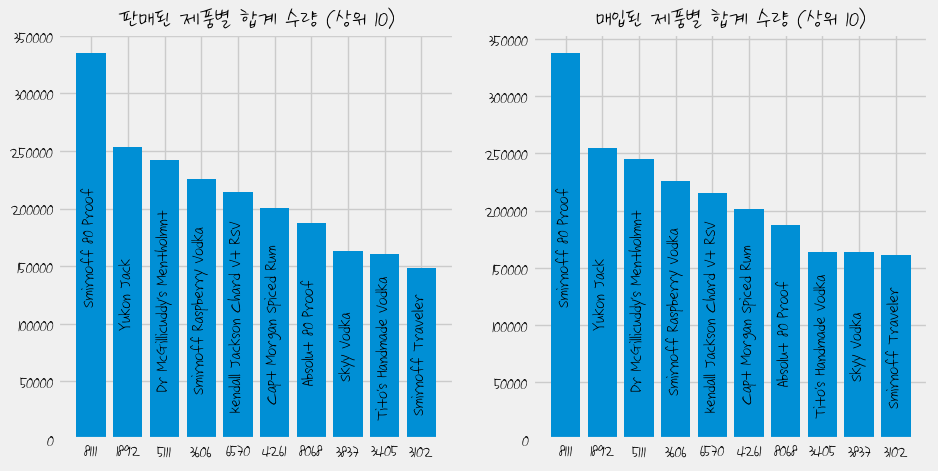

In [32]:
sales_brand_grouped = sales.groupby('Brand')\
                .agg({'SalesQuantity': 'sum',
                      'Description':'first'})\
    .reset_index().sort_values(by = 'SalesQuantity', ascending =False).head(10)

fig, ax = plt.subplots(1,2, figsize=(10,5))

bar_container = ax[0].bar(sales_brand_grouped.Brand, sales_brand_grouped.SalesQuantity)
ax[0].set(title = '판매된 제품별 합계 수량 (상위 10)')
ax[0].bar_label(bar_container, labels=sales_brand_grouped.Description,
             rotation=90,
             label_type='center')

bar_container_1 = ax[1].bar(purc_brand_grouped.Brand, purc_brand_grouped.Quantity)
ax[1].set(title = '매입된 제품별 합계 수량 (상위 10)')
ax[1].bar_label(bar_container_1, labels=purc_brand_grouped.Description,
             rotation=90,
             label_type='center')

Text(0.7, 5799.99, 'max: 5799.99')

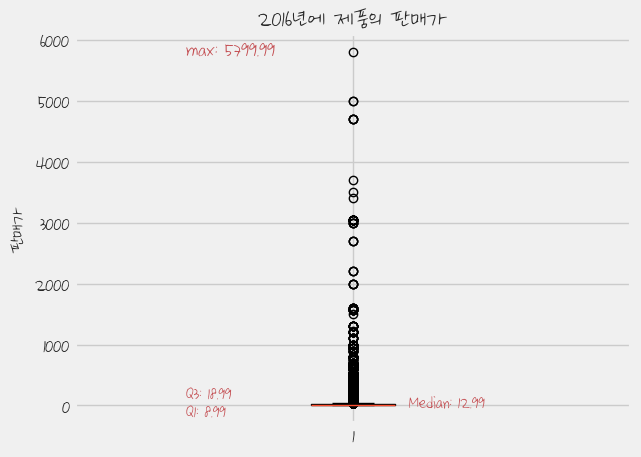

In [212]:
fig, axs = plt.subplots()

axs.boxplot(sales.SalesPrice)
axs.set_title("2016년에 제품의 판매가")
axs.set_ylabel('판매가')

q1_s = np.percentile(sales.SalesPrice, 25)
median_s = np.median(sales.SalesPrice)
q3_s = np.percentile(sales.SalesPrice, 75)
max_s = np.max(sales.SalesPrice)

axs.text(1.1, median_s, f'Median: {median_s:.2f}', va = 'center', color = 'r')
axs.text(0.7, q1_s, f'Q1: {q1_s:.2f}', va = 'top', color = 'r')
axs.text(0.7, q3_s, f'Q3: {q3_s:.2f}', va = 'bottom', color = 'r')
axs.text(0.7, max_s, f'max: {max_s:.2f}', va = 'center', color = 'r', fontsize = 17)

Text(0, 0.5, '판매된 수량')

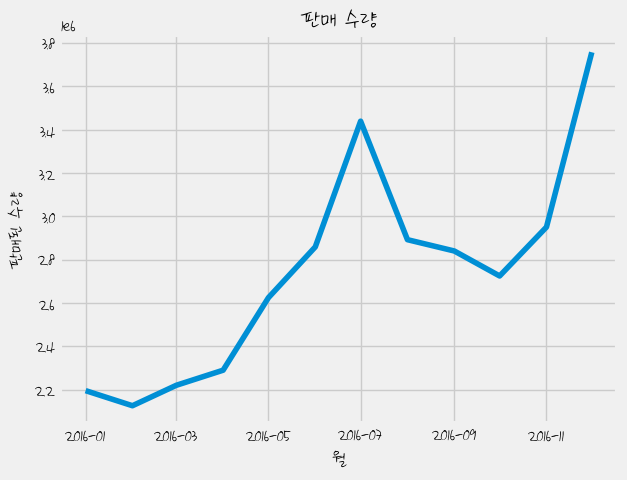

In [34]:
sales['SalesMonth'] = sales.SalesDate.dt.to_period('M')
sales_group_month = sales.groupby('SalesMonth')['SalesQuantity'].sum().reset_index()
sales_group_month['SalesMonth'] = sales_group_month['SalesMonth'].dt.to_timestamp()
plt.plot(sales_group_month.SalesMonth, sales_group_month.SalesQuantity)
plt.title('판매 수량')
plt.xlabel('월')
plt.ylabel('판매된 수량')

In [35]:
sales.groupby('Brand')['SalesPrice'].nunique()

Brand
100      2
1000     4
10009    1
1001     1
10010    1
        ..
994      2
995      3
996      1
998      3
999      2
Name: SalesPrice, Length: 11237, dtype: int64

> 일년간 제품 매출 가격에 변동이 있었기 때문에, 매출 데이터 처리 시에는 각 제품의 평균 판매 가격을 적용하여 수익을 계산할 계획입니다.

In [36]:
sales[sales['SalesPrice']==0]

,InventoryId,Store,Brand,Description,Size,SalesQuantity,SalesDollars,SalesPrice,SalesDate,Volume,Classification,ExciseTax,VendorNo,VendorName,SalesMonth
1251465,38_GOULCREST_25340,38,25340,Dom La Soumade Rast Prestige,750mL,3,0.0,0.0,2016-02-13,750.0,2,0.34,4425,MARTIGNETTI COMPANIES,2016-02
1572292,66_EANVERNESS_25340,66,25340,Dom La Soumade Rast Prestige,750mL,3,0.0,0.0,2016-02-12,750.0,2,0.34,4425,MARTIGNETTI COMPANIES,2016-02
1572293,66_EANVERNESS_25340,66,25340,Dom La Soumade Rast Prestige,750mL,1,0.0,0.0,2016-02-16,750.0,2,0.11,4425,MARTIGNETTI COMPANIES,2016-02
1602468,67_EANVERNESS_25340,67,25340,Dom La Soumade Rast Prestige,750mL,12,0.0,0.0,2016-02-07,750.0,2,1.35,4425,MARTIGNETTI COMPANIES,2016-02
1713234,73_DONCASTER_25340,73,25340,Dom La Soumade Rast Prestige,750mL,1,0.0,0.0,2016-02-15,750.0,2,0.11,4425,MARTIGNETTI COMPANIES,2016-02
3781435,15_WANBORNE_19465,15,19465,Flagstone Longitude Red,750mL,13,0.0,0.0,2016-05-02,750.0,2,1.46,2000,SOUTHERN WINE & SPIRITS NE,2016-05
3876771,23_ARBINGTON_19465,23,19465,Flagstone Longitude Red,750mL,6,0.0,0.0,2016-05-04,750.0,2,0.68,2000,SOUTHERN WINE & SPIRITS NE,2016-05
3995644,34_PITMERDEN_19465,34,19465,Flagstone Longitude Red,750mL,1,0.0,0.0,2016-05-02,750.0,2,0.11,2000,SOUTHERN WINE & SPIRITS NE,2016-05
4251446,54_GUTHRAM_19465,54,19465,Flagstone Longitude Red,750mL,1,0.0,0.0,2016-05-02,750.0,2,0.11,2000,SOUTHERN WINE & SPIRITS NE,2016-05
4251447,54_GUTHRAM_19465,54,19465,Flagstone Longitude Red,750mL,2,0.0,0.0,2016-05-04,750.0,2,0.22,2000,SOUTHERN WINE & SPIRITS NE,2016-05


In [37]:
sales[sales['Brand']== '3046']['SalesPrice'].unique()

array([56.99, 47.99, 48.99,  0.  ])

> 일부 제품은 프로모션으로 무료 증정된 내역이 있어 `SalesDollars`가 0인 행 제거  
> 분석에 필요한 열(`Brand`, `SalesQuantity`, `SalesDollars`, `ExciseTax`)만 추출  
> 세금을 제외한 순매출(`NetSales`) 계산: SalesDollars - ExciseTax  
> 원본 금액 열(`SalesDollars`, `ExciseTax`) 삭제

In [38]:
sold_products = sales[sales['SalesDollars']!=0][['Brand', 'SalesQuantity', 'SalesDollars', 'ExciseTax']]
sold_products['NetSales'] = sold_products['SalesDollars'] - sold_products['ExciseTax']
sold_products = sold_products.drop(columns =['ExciseTax', 'SalesDollars'])

array([[<Axes: title={'center': 'SalesQuantity'}>,
        <Axes: title={'center': 'NetSales'}>]], dtype=object)

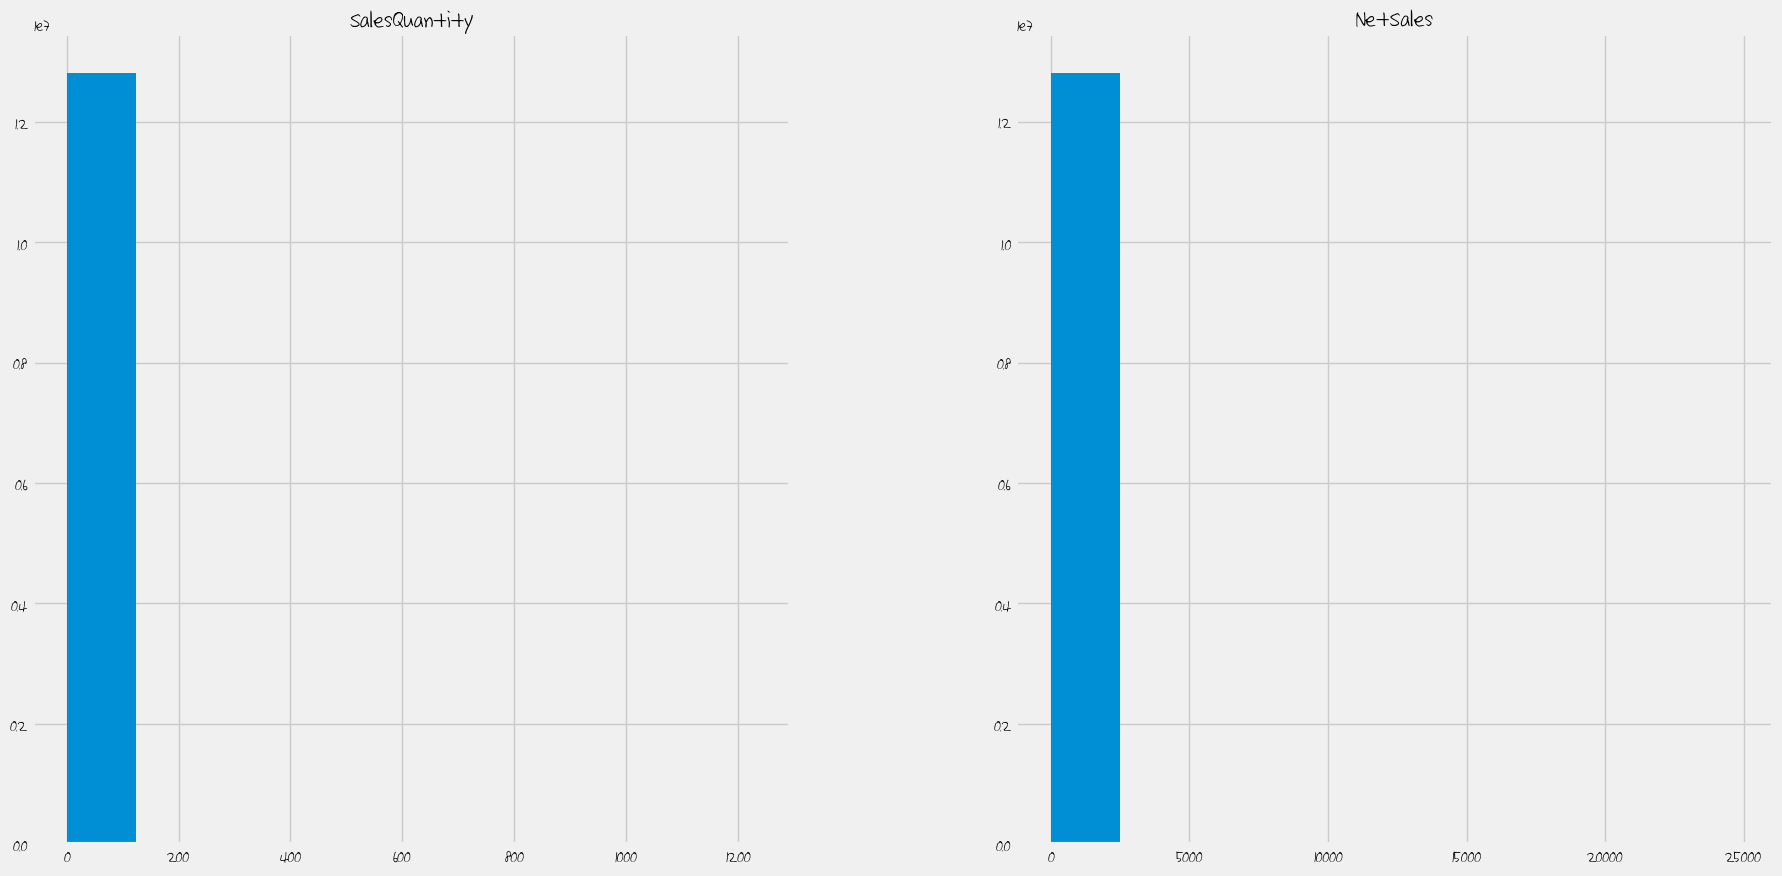

In [39]:
sold_products.hist(figsize = (20,10))

In [40]:
pd.set_option('display.float_format', '{:,.2f}'.format)
sold_products.describe()

,SalesQuantity,NetSales
count,"12,825,308.00","12,825,308.00"
mean,2.57,33.77
std,4.55,84.79
min,1.00,0.44
25%,1.00,10.47
50%,1.00,18.15
75%,2.00,33.76
max,"1,231.00","24,818.40"


> 브랜드별로 그룹화하여   
> 총 판매 수량(`SalesQuantity`) 합계 계산  
> 순매출(`NetSales`) 합계 계산   
> 브랜드별 평균 판매가(`AvgPrice`) 계산: `NetSales` ÷ `SalesQuantity`

In [41]:
sold_product_grouped = sold_products.groupby('Brand')\
    .agg({'SalesQuantity': 'sum',
          'NetSales' :'sum'})
sold_product_grouped['AvgPrice'] = sold_product_grouped['NetSales']/sold_product_grouped['SalesQuantity']

In [42]:
sold_product_grouped

,SalesQuantity,NetSales,AvgPrice
Brand,,,
100,124,"20,170.98",162.67
1000,62,988.50,15.94
10009,35,205.74,5.88
1001,7927,"47,073.23",5.94
10010,6,35.28,5.88
...,...,...,...
994,132,"2,658.08",20.14
995,188,"3,682.72",19.59
996,15,"4,488.00",299.20


### 제품별 수익 데이플 생성

In [43]:
profit_table  = sold_product_grouped.merge(total_stock[['Brand','PurchasePrice']], on = 'Brand', how = 'left')

In [44]:
profit_table.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11237 entries, 0 to 11236
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Brand          11237 non-null  object 
 1   SalesQuantity  11237 non-null  int64  
 2   NetSales       11237 non-null  float64
 3   AvgPrice       11237 non-null  float64
 4   PurchasePrice  10485 non-null  float64
dtypes: float64(3), int64(1), object(1)
memory usage: 439.1+ KB


In [45]:
profit_table

,Brand,SalesQuantity,NetSales,AvgPrice,PurchasePrice
0,100,124,"20,170.98",162.67,120.29
1,1000,62,988.50,15.94,11.62
2,10009,35,205.74,5.88,4.13
3,1001,7927,"47,073.23",5.94,4.28
4,10010,6,35.28,5.88,3.86
...,...,...,...,...,...
11232,994,132,"2,658.08",20.14,14.81
11233,995,188,"3,682.72",19.59,15.99
11234,996,15,"4,488.00",299.20,222.21
11235,998,676,"16,974.11",25.11,18.51


> 제품 구매 가격 값 중에 결측치 있습니다.
> 결측치를 채우기 위한 제품 판매가격을 정할 때 적용하는 마크업을 계산하려고 합니다

In [46]:
profit_table_markup = profit_table[profit_table['PurchasePrice'].notna()].copy()

In [47]:
profit_table_markup.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10485 entries, 0 to 11236
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Brand          10485 non-null  object 
 1   SalesQuantity  10485 non-null  int64  
 2   NetSales       10485 non-null  float64
 3   AvgPrice       10485 non-null  float64
 4   PurchasePrice  10485 non-null  float64
dtypes: float64(3), int64(1), object(1)
memory usage: 491.5+ KB


In [48]:
profit_table_markup['Markup'] = profit_table_markup['AvgPrice'].div(profit_table_markup['PurchasePrice']).sub(1)
avg_markup = profit_table_markup['Markup'].mean()
avg_markup

np.float64(0.4572397549968067)

In [49]:
profit_table['PurchasePrice'] = profit_table['PurchasePrice'].fillna(profit_table['AvgPrice']/(1+avg_markup))
profit_table['TTLPurchase'] = profit_table['PurchasePrice'] *profit_table['SalesQuantity'] 
profit_table['Profit'] = profit_table['NetSales'] - profit_table['TTLPurchase']
profit_table.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11237 entries, 0 to 11236
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Brand          11237 non-null  object 
 1   SalesQuantity  11237 non-null  int64  
 2   NetSales       11237 non-null  float64
 3   AvgPrice       11237 non-null  float64
 4   PurchasePrice  11237 non-null  float64
 5   TTLPurchase    11237 non-null  float64
 6   Profit         11237 non-null  float64
dtypes: float64(5), int64(1), object(1)
memory usage: 614.7+ KB


## 4. ABC 분석

> `Profit` 기준 내림차순으로 정렬  
> 누적 이익(`Run_Profit`) 계산  
> 전체 이익 합계(`total_profit_value`) 계산  
> 누적 이익 비율(`run_perc`) 계산: `Run_Profit` ÷ `total_profit_value`

In [50]:
profit_table = profit_table.sort_values(by='Profit', ascending = False)

In [51]:
profit_table['Run_Profit'] = profit_table['Profit'].cumsum()

In [52]:
total_profit_value = profit_table['Profit'].sum()
total_profit_value

np.float64(119638030.5185386)

In [53]:
profit_table['run_perc'] = profit_table['Run_Profit']/total_profit_value

In [54]:
profit_table

,Brand,SalesQuantity,NetSales,AvgPrice,PurchasePrice,TTLPurchase,Profit,Run_Profit,run_perc
476,1233,142049,"4,840,920.31",34.08,26.27,"3,731,627.23","1,109,293.08","1,109,293.08",0.01
7740,3545,135838,"3,973,519.79",29.25,21.89,"2,973,493.82","1,000,025.97","2,109,319.05",0.02
8910,4261,200412,"4,107,730.08",20.50,16.17,"3,240,662.04","867,068.04","2,976,387.09",0.02
10319,6570,214238,"2,301,924.01",10.74,6.77,"1,450,391.26","851,532.75","3,827,919.84",0.03
7543,3405,160247,"4,524,634.83",28.24,23.19,"3,716,127.93","808,506.90","4,636,426.74",0.04
...,...,...,...,...,...,...,...,...,...
149,10666,5636,"30,556.40",5.42,7.74,"43,622.64","-13,066.24","119,712,983.58",1.00
7440,33331,7236,"64,254.63",8.88,10.73,"77,642.28","-13,387.65","119,699,595.93",1.00
9273,44714,9925,"118,508.31",11.94,13.51,"134,086.75","-15,578.44","119,684,017.49",1.00
6282,26710,4995,"25,471.13",5.10,9.26,"46,253.70","-20,782.57","119,663,234.92",1.00


> 누적 이익 비율(`run_perc`)을 기준으로 ABC 분석 카테고리 지정

In [55]:
def ABC(run_perc):
    if run_perc > 0 and run_perc < 0.8:
        return 'A'
    elif run_perc >= 0.8 and run_perc < 0.95:
        return 'B'
    elif run_perc >= 0.95:
        return 'C'
profit_table['ABC_category'] = profit_table['run_perc'].apply(ABC)

In [56]:
profit_table

,Brand,SalesQuantity,NetSales,AvgPrice,PurchasePrice,TTLPurchase,Profit,Run_Profit,run_perc,ABC_category
476,1233,142049,"4,840,920.31",34.08,26.27,"3,731,627.23","1,109,293.08","1,109,293.08",0.01,A
7740,3545,135838,"3,973,519.79",29.25,21.89,"2,973,493.82","1,000,025.97","2,109,319.05",0.02,A
8910,4261,200412,"4,107,730.08",20.50,16.17,"3,240,662.04","867,068.04","2,976,387.09",0.02,A
10319,6570,214238,"2,301,924.01",10.74,6.77,"1,450,391.26","851,532.75","3,827,919.84",0.03,A
7543,3405,160247,"4,524,634.83",28.24,23.19,"3,716,127.93","808,506.90","4,636,426.74",0.04,A
...,...,...,...,...,...,...,...,...,...,...
149,10666,5636,"30,556.40",5.42,7.74,"43,622.64","-13,066.24","119,712,983.58",1.00,C
7440,33331,7236,"64,254.63",8.88,10.73,"77,642.28","-13,387.65","119,699,595.93",1.00,C
9273,44714,9925,"118,508.31",11.94,13.51,"134,086.75","-15,578.44","119,684,017.49",1.00,C
6282,26710,4995,"25,471.13",5.10,9.26,"46,253.70","-20,782.57","119,663,234.92",1.00,C


In [57]:
category_share = profit_table['ABC_category'].value_counts()
category_share = category_share.reset_index()
category_share.columns = ['Category', 'Count']

Text(0.5, 1.0, 'ABC 카테고리 제품 종류의 비율')

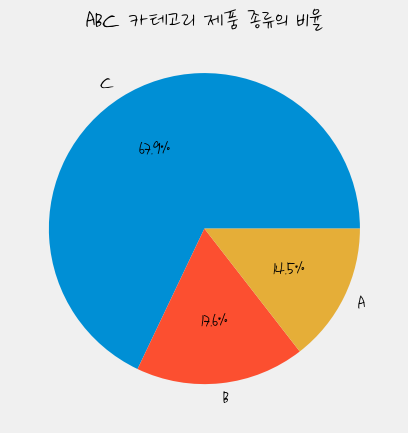

In [58]:
category_share.Count.sum()
ttl = profit_table['ABC_category'].value_counts().sum()
category_share['Perc'] = (category_share.Count/ttl)*100

plt.pie(category_share.Perc, labels = ['C', 'B', 'A'], autopct='%1.1f%%', textprops={'fontsize': 16})
plt.title('ABC 카테고리 제품 종류의 비율')

## 5. XYZ 분석

In [59]:
sales.head()

,InventoryId,Store,Brand,Description,Size,SalesQuantity,SalesDollars,SalesPrice,SalesDate,Volume,Classification,ExciseTax,VendorNo,VendorName,SalesMonth
0,1_HARDERSFIELD_1004,1,1004,Jim Beam w/2 Rocks Glasses,750mL,1,16.49,16.49,2016-01-01,750.00,1,0.79,12546,JIM BEAM BRANDS COMPANY,2016-01
1,1_HARDERSFIELD_1004,1,1004,Jim Beam w/2 Rocks Glasses,750mL,2,32.98,16.49,2016-01-02,750.00,1,1.57,12546,JIM BEAM BRANDS COMPANY,2016-01
2,1_HARDERSFIELD_1004,1,1004,Jim Beam w/2 Rocks Glasses,750mL,1,16.49,16.49,2016-01-03,750.00,1,0.79,12546,JIM BEAM BRANDS COMPANY,2016-01
3,1_HARDERSFIELD_1004,1,1004,Jim Beam w/2 Rocks Glasses,750mL,1,14.49,14.49,2016-01-08,750.00,1,0.79,12546,JIM BEAM BRANDS COMPANY,2016-01
4,1_HARDERSFIELD_1005,1,1005,Maker's Mark Combo Pack,375mL 2 Pk,2,69.98,34.99,2016-01-09,375.00,1,0.79,12546,JIM BEAM BRANDS COMPANY,2016-01


> 판매 데이터에서 `Brand`, `SalesQuantity`, `SalesDate` 열만 추출  
> 판매일자를 월 단위로 변환(`SaleMonth`)  
> 브랜드와 월별로 그룹화하여 해당 월의 총 판매 수량 합계 계산

In [60]:
sales_frequency = sales[['Brand', 'SalesQuantity', 'SalesDate']].copy()
sales_frequency['SaleMonth'] = sales_frequency['SalesDate'].dt.to_period('M')
sales_frequency = sales_frequency.drop(columns = ['SalesDate'])
sales_frequency_grouped = sales_frequency.groupby(['Brand', 'SaleMonth'])['SalesQuantity'].sum()
sales_frequency_grouped

Brand  SaleMonth
100    2016-01        7
       2016-02       11
       2016-03        5
       2016-04       15
       2016-05        7
                   ... 
999    2016-08       44
       2016-09       45
       2016-10       40
       2016-11       40
       2016-12      155
Name: SalesQuantity, Length: 94088, dtype: int64

> 월별 판매 빈도를 계산하기 위해 월별 판매 수량을 제품별로 피벗 테이블 형태로 변환  
> 결측값은 0으로 채움

In [61]:
sales_by_month = sales_frequency_grouped.reset_index()\
    .pivot(index ='Brand',
           columns ='SaleMonth',
           values = 'SalesQuantity').fillna(0)

> 제품별 월별 평균 판매량과 표준편차를 계산  
> 변동계수(CV) 계산: StdSales ÷ AvgSalesQ-ty

In [62]:
sales_by_month['AvgSalesQ-ty'] = sales_by_month.mean(axis = 1)
sales_by_month['StdSales'] = sales_by_month.std(axis = 1)
sales_by_month['CV'] = sales_by_month['StdSales']/sales_by_month['AvgSalesQ-ty']

In [63]:
sales_by_month

SaleMonth,2016-01,2016-02,2016-03,2016-04,2016-05,2016-06,2016-07,2016-08,2016-09,2016-10,2016-11,2016-12,AvgSalesQ-ty,StdSales,CV
Brand,,,,,,,,,,,,,,,
100,7.00,11.00,5.00,15.00,7.00,19.00,17.00,4.00,7.00,7.00,12.00,13.00,10.33,4.70,0.45
1000,28.00,21.00,6.00,6.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,5.17,9.03,1.75
10009,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,2.00,32.00,2.92,8.79,3.01
1001,833.00,357.00,204.00,66.00,76.00,25.00,421.00,"1,184.00","1,458.00","1,329.00","1,331.00",643.00,660.58,523.88,0.79
10010,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,5.00,0.00,0.00,1.00,0.50,1.38,2.77
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
994,13.00,15.00,10.00,15.00,13.00,14.00,13.00,3.00,4.00,10.00,12.00,10.00,11.00,3.76,0.34
995,12.00,19.00,16.00,25.00,21.00,19.00,15.00,19.00,6.00,12.00,11.00,13.00,15.67,4.99,0.32
996,0.00,1.00,1.00,0.00,0.00,2.00,3.00,2.00,4.00,1.00,1.00,0.00,1.25,1.23,0.99


sales_by_month['CV'].describe()

> 제품 수요 변동 계수(CV)의 중앙값이 0.92이므로,  
> 제품 수요 분포를 반영하여 카테고리를 합리적으로 구분하기 위해  
> 기준점을 0.5와 1로 지정

In [64]:
def xyz(cv):
    if cv <= 0.5:
        return 'X'
    elif cv <= 1:
        return 'Y'
    else:
        return 'Z'

In [65]:
sales_by_month['XYZ_Category'] = sales_by_month['CV'].apply(xyz)

In [66]:
sales_by_month

SaleMonth,2016-01,2016-02,2016-03,2016-04,2016-05,2016-06,2016-07,2016-08,2016-09,2016-10,2016-11,2016-12,AvgSalesQ-ty,StdSales,CV,XYZ_Category
Brand,,,,,,,,,,,,,,,,
100,7.00,11.00,5.00,15.00,7.00,19.00,17.00,4.00,7.00,7.00,12.00,13.00,10.33,4.70,0.45,X
1000,28.00,21.00,6.00,6.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,5.17,9.03,1.75,Z
10009,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,2.00,32.00,2.92,8.79,3.01,Z
1001,833.00,357.00,204.00,66.00,76.00,25.00,421.00,"1,184.00","1,458.00","1,329.00","1,331.00",643.00,660.58,523.88,0.79,Y
10010,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,5.00,0.00,0.00,1.00,0.50,1.38,2.77,Z
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
994,13.00,15.00,10.00,15.00,13.00,14.00,13.00,3.00,4.00,10.00,12.00,10.00,11.00,3.76,0.34,X
995,12.00,19.00,16.00,25.00,21.00,19.00,15.00,19.00,6.00,12.00,11.00,13.00,15.67,4.99,0.32,X
996,0.00,1.00,1.00,0.00,0.00,2.00,3.00,2.00,4.00,1.00,1.00,0.00,1.25,1.23,0.99,Y


In [67]:
XYZ_category_share = sales_by_month['XYZ_Category'].value_counts()
XYZ_category_share = XYZ_category_share.reset_index()
XYZ_category_share.columns = ['Category', 'Count']

Text(0.5, 1.0, 'XYZ 카테고리별 제품 종류의 비율')

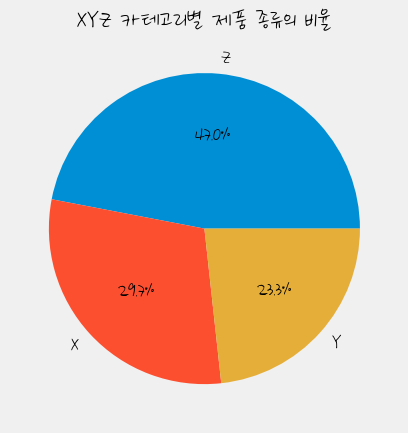

In [68]:
XYZ_category_share['Perc'] = (XYZ_category_share.Count/ttl) * 100 
plt.pie(XYZ_category_share.Count, labels = XYZ_category_share.Category, autopct = '%1.1f%%', textprops = {'fontsize': 16})
plt.title('XYZ 카테고리별 제품 종류의 비율')


## 6. Dead Stock

> 매출 기록이 있는 InventoryId 리스트 생성 후  
> 기초 재고 데이터에서 해당 InventoryId가 없는 건 추출

In [69]:
sales_id_series = pd.Series(sales['InventoryId'].unique(), name = 'InventoryId')

In [70]:
dead_stock  = srtinv[~srtinv['InventoryId'].isin(sales_id_series)]

In [71]:
dead_stock = dead_stock[['InventoryId','Brand', 'Store', 'Description', 'onHand', 'Price']]

In [72]:
dead_stock

,InventoryId,Brand,Store,Description,onHand,Price
30,1_HARDERSFIELD_356,356,1,Carolans Irish Cr Gift Set,0,11.49
41,1_HARDERSFIELD_425,425,1,Hennessy Paradis,1,799.99
101,1_HARDERSFIELD_883,883,1,Patron Burdeos Anejo Tequila,2,499.99
114,1_HARDERSFIELD_999,999,1,Jameson 18 Year Old,0,119.99
115,1_HARDERSFIELD_1000,1000,1,Goslings Dark'n Stormy VAP,0,14.99
...,...,...,...,...,...,...
205685,79_BALLYMENA_22759,22759,79,Meiomi Pnt Nr,0,12.99
205746,79_BALLYMENA_23848,23848,79,Dom Cherrier Sancerre,0,17.99
205765,79_BALLYMENA_24328,24328,79,Ch Ducru Beaucaillou 12 St J,5,154.99
206171,79_BALLYMENA_36766,36766,79,Ravenswood Znfdl Lodi,0,16.99


In [73]:
dead_stock = dead_stock[dead_stock['onHand'] !=0]

> 제품별 구매가 불러오기

In [74]:
dead_stock = dead_stock.merge(year_stock_grouped[['Brand', 'PurchasePrice']], on = 'Brand', how = 'left')

In [75]:
dead_stock.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 938 entries, 0 to 937
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   InventoryId    938 non-null    object 
 1   Brand          938 non-null    object 
 2   Store          938 non-null    object 
 3   Description    938 non-null    object 
 4   onHand         938 non-null    int64  
 5   Price          938 non-null    float64
 6   PurchasePrice  842 non-null    float64
dtypes: float64(2), int64(1), object(4)
memory usage: 51.4+ KB


In [76]:
dead_stock['PurchasePrice'] = dead_stock['PurchasePrice']\
    .fillna(dead_stock['Price']/(1+avg_markup))

In [77]:
dead_stock.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 938 entries, 0 to 937
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   InventoryId    938 non-null    object 
 1   Brand          938 non-null    object 
 2   Store          938 non-null    object 
 3   Description    938 non-null    object 
 4   onHand         938 non-null    int64  
 5   Price          938 non-null    float64
 6   PurchasePrice  938 non-null    float64
dtypes: float64(2), int64(1), object(4)
memory usage: 51.4+ KB


In [78]:
# Tableau 대시보드용 데이터파일 
#dead_stock.to_csv('dead_stock.csv', index = False)

In [79]:
dead_stock_grouped = dead_stock.groupby(['Brand', 'Description'])\
    .agg({'onHand' : 'sum',
          'Price' : 'first',
          'PurchasePrice': 'first',
          'Store' : lambda x : len(set(x))})

In [80]:
dead_stock_grouped = dead_stock_grouped.rename(columns = {'Store' : 'NumberOfStores', 'onHand' : 'Quantity'})

In [81]:
dead_stock_grouped.sort_values(by = 'NumberOfStores', ascending = False)

,,Quantity,Price,PurchasePrice,NumberOfStores
Brand,Description,,,,
5370,DiSaronno Rsva Ltd Edition,18,349.99,255.47,11
1106,Aberfeldy Single Cask,120,229.99,155.55,11
5430,Grand Marnier Cuvee 1880,39,349.99,275.58,10
2532,The Macallan 12 Yr Old,39,134.99,96.89,8
425,Hennessy Paradis,10,799.99,620.15,8
...,...,...,...,...,...
976,McCormick Gold Label Bourbon,2,9.49,7.47,1
977,McCormick Scotch,3,11.49,8.98,1
979,Pancho Villa Rojo,3,7.79,5.90,1


## 7. Summary

In [82]:
summary_table = pd.merge(profit_table[['Brand', 'SalesQuantity','NetSales', 'Profit','ABC_category']],
                         sales_by_month[['XYZ_Category']],
                         on = 'Brand', how = 'left')

In [83]:
brand_descriptions = sales[['Brand', 'Description']].drop_duplicates(subset='Brand')
summary_table = pd.merge(summary_table, brand_descriptions, on = 'Brand', how = 'left')

In [84]:
summary_table = summary_table[['Brand', 'Description', 'SalesQuantity', 'NetSales', 'Profit' , 'ABC_category', 'XYZ_Category']]

In [85]:
present_stock = endinv.groupby('Brand')['onHand'].sum()
summary_table = pd.merge(summary_table, present_stock, on='Brand', how = 'left').fillna(0)

In [113]:
summary_table.head()

,Brand,Description,SalesQuantity,NetSales,Profit,ABC_category,XYZ_Category,onHand
0,1233,Jack Daniels No 7 Black,142049,"4,840,920.31","1,109,293.08",A,X,"15,047.00"
1,3545,Ketel One Vodka,135838,"3,973,519.79","1,000,025.97",A,X,"16,770.00"
2,4261,Capt Morgan Spiced Rum,200412,"4,107,730.08","867,068.04",A,X,"16,769.00"
3,6570,Kendall Jackson Chard Vt RSV,214238,"2,301,924.01","851,532.75",A,X,"13,016.00"
4,3405,Tito's Handmade Vodka,160247,"4,524,634.83","808,506.90",A,X,"12,268.00"


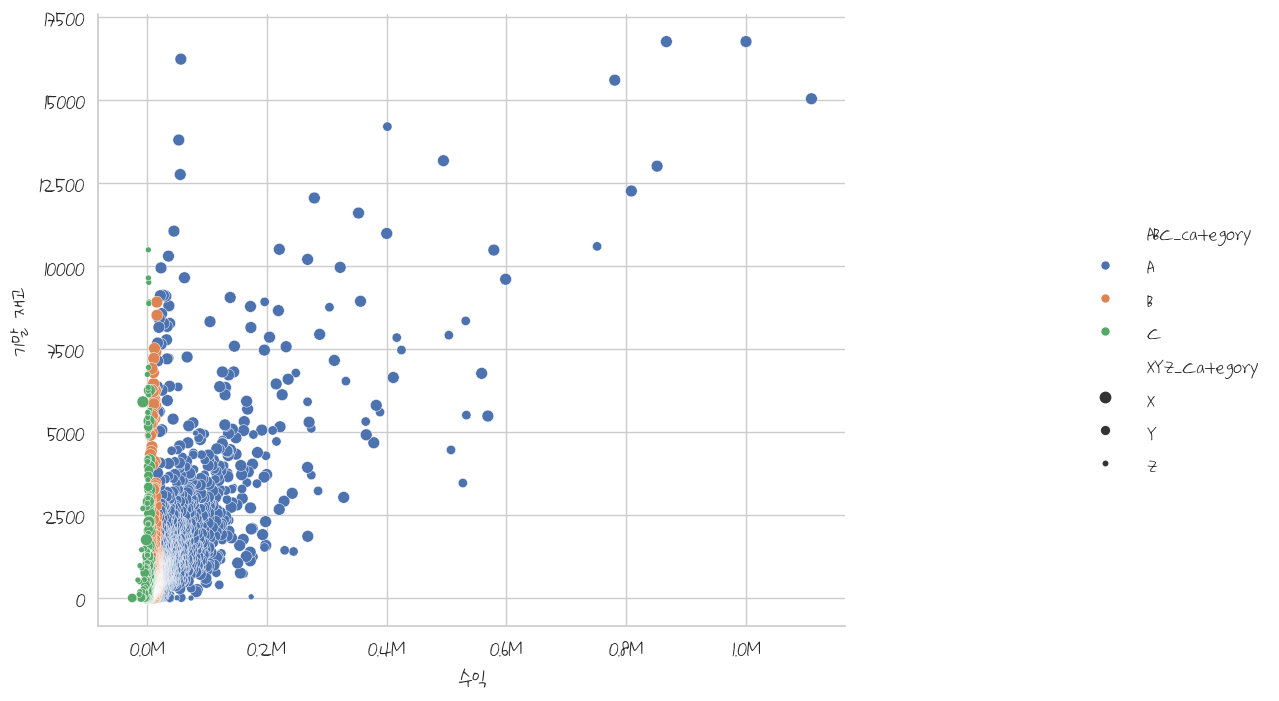

In [156]:
g = sns.relplot(
    data=summary_table,
    x="Profit", y="onHand",
    hue="ABC_category", size="XYZ_Category",
)

plt.ylabel('기말 재고', fontsize=20 )
plt.xlabel('수익', fontsize=20)
plt.tick_params(axis='both', labelsize=20)

ax = g.ax  
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{x*1e-6:.1f}M'.format(x))) 


g.figure.set_size_inches(15, 8)

> 수익이 높은 제품들은 모두 A 카테고리에 속하며,
> 재고량이 많은 제품 중 일부는 C·Z 카테고리dls 제품들이 있습니다

In [88]:
summary_table[
    (summary_table['ABC_category'] =='C') &(summary_table['XYZ_Category'] =='Z') & (summary_table['onHand'] > 5000)]\
    .sort_values(by = 'onHand', ascending = False)

,Brand,Description,SalesQuantity,NetSales,Profit,ABC_category,XYZ_Category,onHand
4908,3581,Pinnacle Citrus,9188,"8,620.39","1,821.27",C,Z,"10,493.00"
4834,3594,Pinnacle Tropical Punch,11443,"10,734.51","1,923.40",C,Z,"9,646.00"
4406,3566,Pinnacle Raspberry,11128,"10,439.27","2,538.39",C,Z,"9,514.00"
4244,3638,Pinnacle Whipped,14844,"13,921.91","2,788.91",C,Z,"8,921.00"
4362,3454,Pinnacle Pineapple,11940,"11,199.70","2,602.90",C,Z,"8,876.00"
4610,2107,Rebel Yell Ginger Bourbon,11208,"10,513.92","2,220.00",C,Z,"6,950.00"
7968,5609,Integre Vodka,430,"2,237.26",224.86,C,Z,"6,741.00"
5115,7956,Bayou Satsuma Rum Liqueur,10626,"9,970.23","1,575.69",C,Z,"6,347.00"
5054,7948,Bayou Silver Rum,7898,"7,411.30","1,645.76",C,Z,"6,259.00"
4570,7936,Bayou Spiced Rum,9943,"9,328.98","2,269.45",C,Z,"6,121.00"


> 상기 제품은 수익 기여도가 낮고 수요 변동성이 커 예측이 어렵지만, 현재 재고가 매우 높은 수준입니다.  
> 매장별 재고 및 판매 현황을 확인할 필요가 있습니다.

In [157]:
# sns.pairplot(data=summary_table, hue="ABC_category")

In [159]:
# sns.pairplot(data=summary_table, hue="XYZ_Category")

In [160]:
summary_table['ABC_XYZ_category'] = summary_table['ABC_category'] + summary_table['XYZ_Category']

Text(0.5, 0, '')

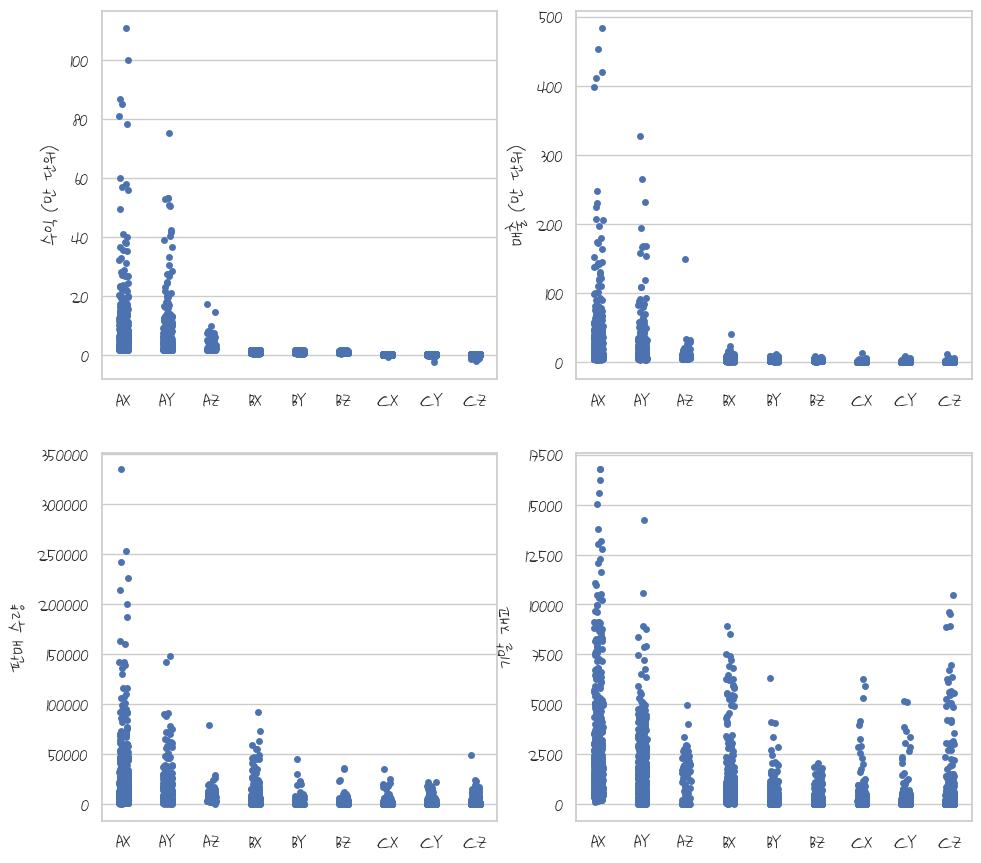

In [164]:
fig, axs = plt.subplots(2,2, figsize = (10,10))

order = ['AX', 'AY', 'AZ', 'BX', 'BY', 'BZ', 'CX', 'CY', 'CZ']
sns.stripplot(x  = summary_table.ABC_XYZ_category, y = summary_table.Profit/10000, jitter = True, ax = axs[0,0], order=order)
axs[0,0].set_ylabel("수익 (만 단위)")
axs[0,0].set_xlabel("")
sns.stripplot(x  = summary_table.ABC_XYZ_category, y = summary_table.NetSales/10000, jitter = True, ax = axs[0,1], order=order)
axs[0,1].set_ylabel("매출 (만 단위)")
axs[0,1].set_xlabel("")
sns.stripplot(x  = summary_table.ABC_XYZ_category, y = summary_table.SalesQuantity, jitter = True, ax = axs[1,0], order=order)
axs[1,0].set_ylabel("판매 수량")
axs[1,0].set_xlabel("")
sns.stripplot(x  = summary_table.ABC_XYZ_category, y = summary_table.onHand, jitter = True, ax = axs[1,1], order=order)
axs[1,1].set_ylabel("기말 재고")
axs[1,1].set_xlabel("")


In [165]:
summary_table

,Brand,Description,SalesQuantity,NetSales,Profit,ABC_category,XYZ_Category,onHand,ABC_XYZ_category
0,1233,Jack Daniels No 7 Black,142049,"4,840,920.31","1,109,293.08",A,X,"15,047.00",AX
1,3545,Ketel One Vodka,135838,"3,973,519.79","1,000,025.97",A,X,"16,770.00",AX
2,4261,Capt Morgan Spiced Rum,200412,"4,107,730.08","867,068.04",A,X,"16,769.00",AX
3,6570,Kendall Jackson Chard Vt RSV,214238,"2,301,924.01","851,532.75",A,X,"13,016.00",AX
4,3405,Tito's Handmade Vodka,160247,"4,524,634.83","808,506.90",A,X,"12,268.00",AX
...,...,...,...,...,...,...,...,...,...
11232,10666,Clayhouse Adobe Cntrl Cst Wh,5636,"30,556.40","-13,066.24",C,Z,491.00,CZ
11233,33331,Moletto Prosecco Della Marc,7236,"64,254.63","-13,387.65",C,Z,107.00,CZ
11234,44714,Buehler Znfdl Napa,9925,"118,508.31","-15,578.44",C,Z,542.00,CZ
11235,26710,Feudi Di San Gregorio Fiano,4995,"25,471.13","-20,782.57",C,Z,0.00,CZ


In [166]:
category_summary = summary_table.groupby('ABC_XYZ_category').agg(
    NumberOfItems=('ABC_XYZ_category', 'count'),
    SalesQuantity=('SalesQuantity', 'sum'),
    Profit=('Profit', 'sum'),
    NetSales=('NetSales', 'sum'),
    CurrentStock=('onHand', 'sum')
)
category_summary['ItemShare'] = category_summary['NumberOfItems']/category_summary['NumberOfItems'].sum().round(2)
category_summary['SalesQuantityShare'] = category_summary['SalesQuantity']/category_summary['SalesQuantity'].sum().round(2)
category_summary['ProfitShare'] = category_summary['Profit']/category_summary['Profit'].sum().round(2)
category_summary['NetSalesShare'] = category_summary['NetSales']/category_summary['NetSales'].sum().round(2)
category_summary['StockShare'] = category_summary['CurrentStock']/category_summary['CurrentStock'].sum().round(2)

In [167]:
category_summary

,NumberOfItems,SalesQuantity,Profit,NetSales,CurrentStock,ItemShare,SalesQuantityShare,ProfitShare,NetSalesShare,StockShare
ABC_XYZ_category,,,,,,,,,,
AX,1111,17179972,"63,319,838.69","241,139,704.13","2,049,561.00",0.10,0.52,0.53,0.56,0.42
AY,440,6097776,"29,526,735.79","91,688,039.88","840,049.00",0.04,0.19,0.25,0.21,0.17
AZ,78,713323,"2,860,404.66","9,732,571.05","91,145.00",0.01,0.02,0.02,0.02,0.02
BX,1362,4687470,"12,784,249.73","46,379,010.23","855,211.00",0.12,0.14,0.11,0.11,0.18
BY,387,876981,"3,367,582.56","11,709,179.64","175,949.00",0.03,0.03,0.03,0.03,0.04
BZ,226,553319,"1,796,862.45","6,236,326.22","73,087.00",0.02,0.02,0.02,0.01,0.01
CX,870,832546,"1,897,567.12","6,993,845.45","193,875.00",0.08,0.03,0.02,0.02,0.04
CY,1788,817052,"2,111,787.29","9,239,836.99","189,562.00",0.16,0.02,0.02,0.02,0.04
CZ,4975,1159314,"1,973,002.23","9,970,289.38","404,466.00",0.44,0.04,0.02,0.02,0.08


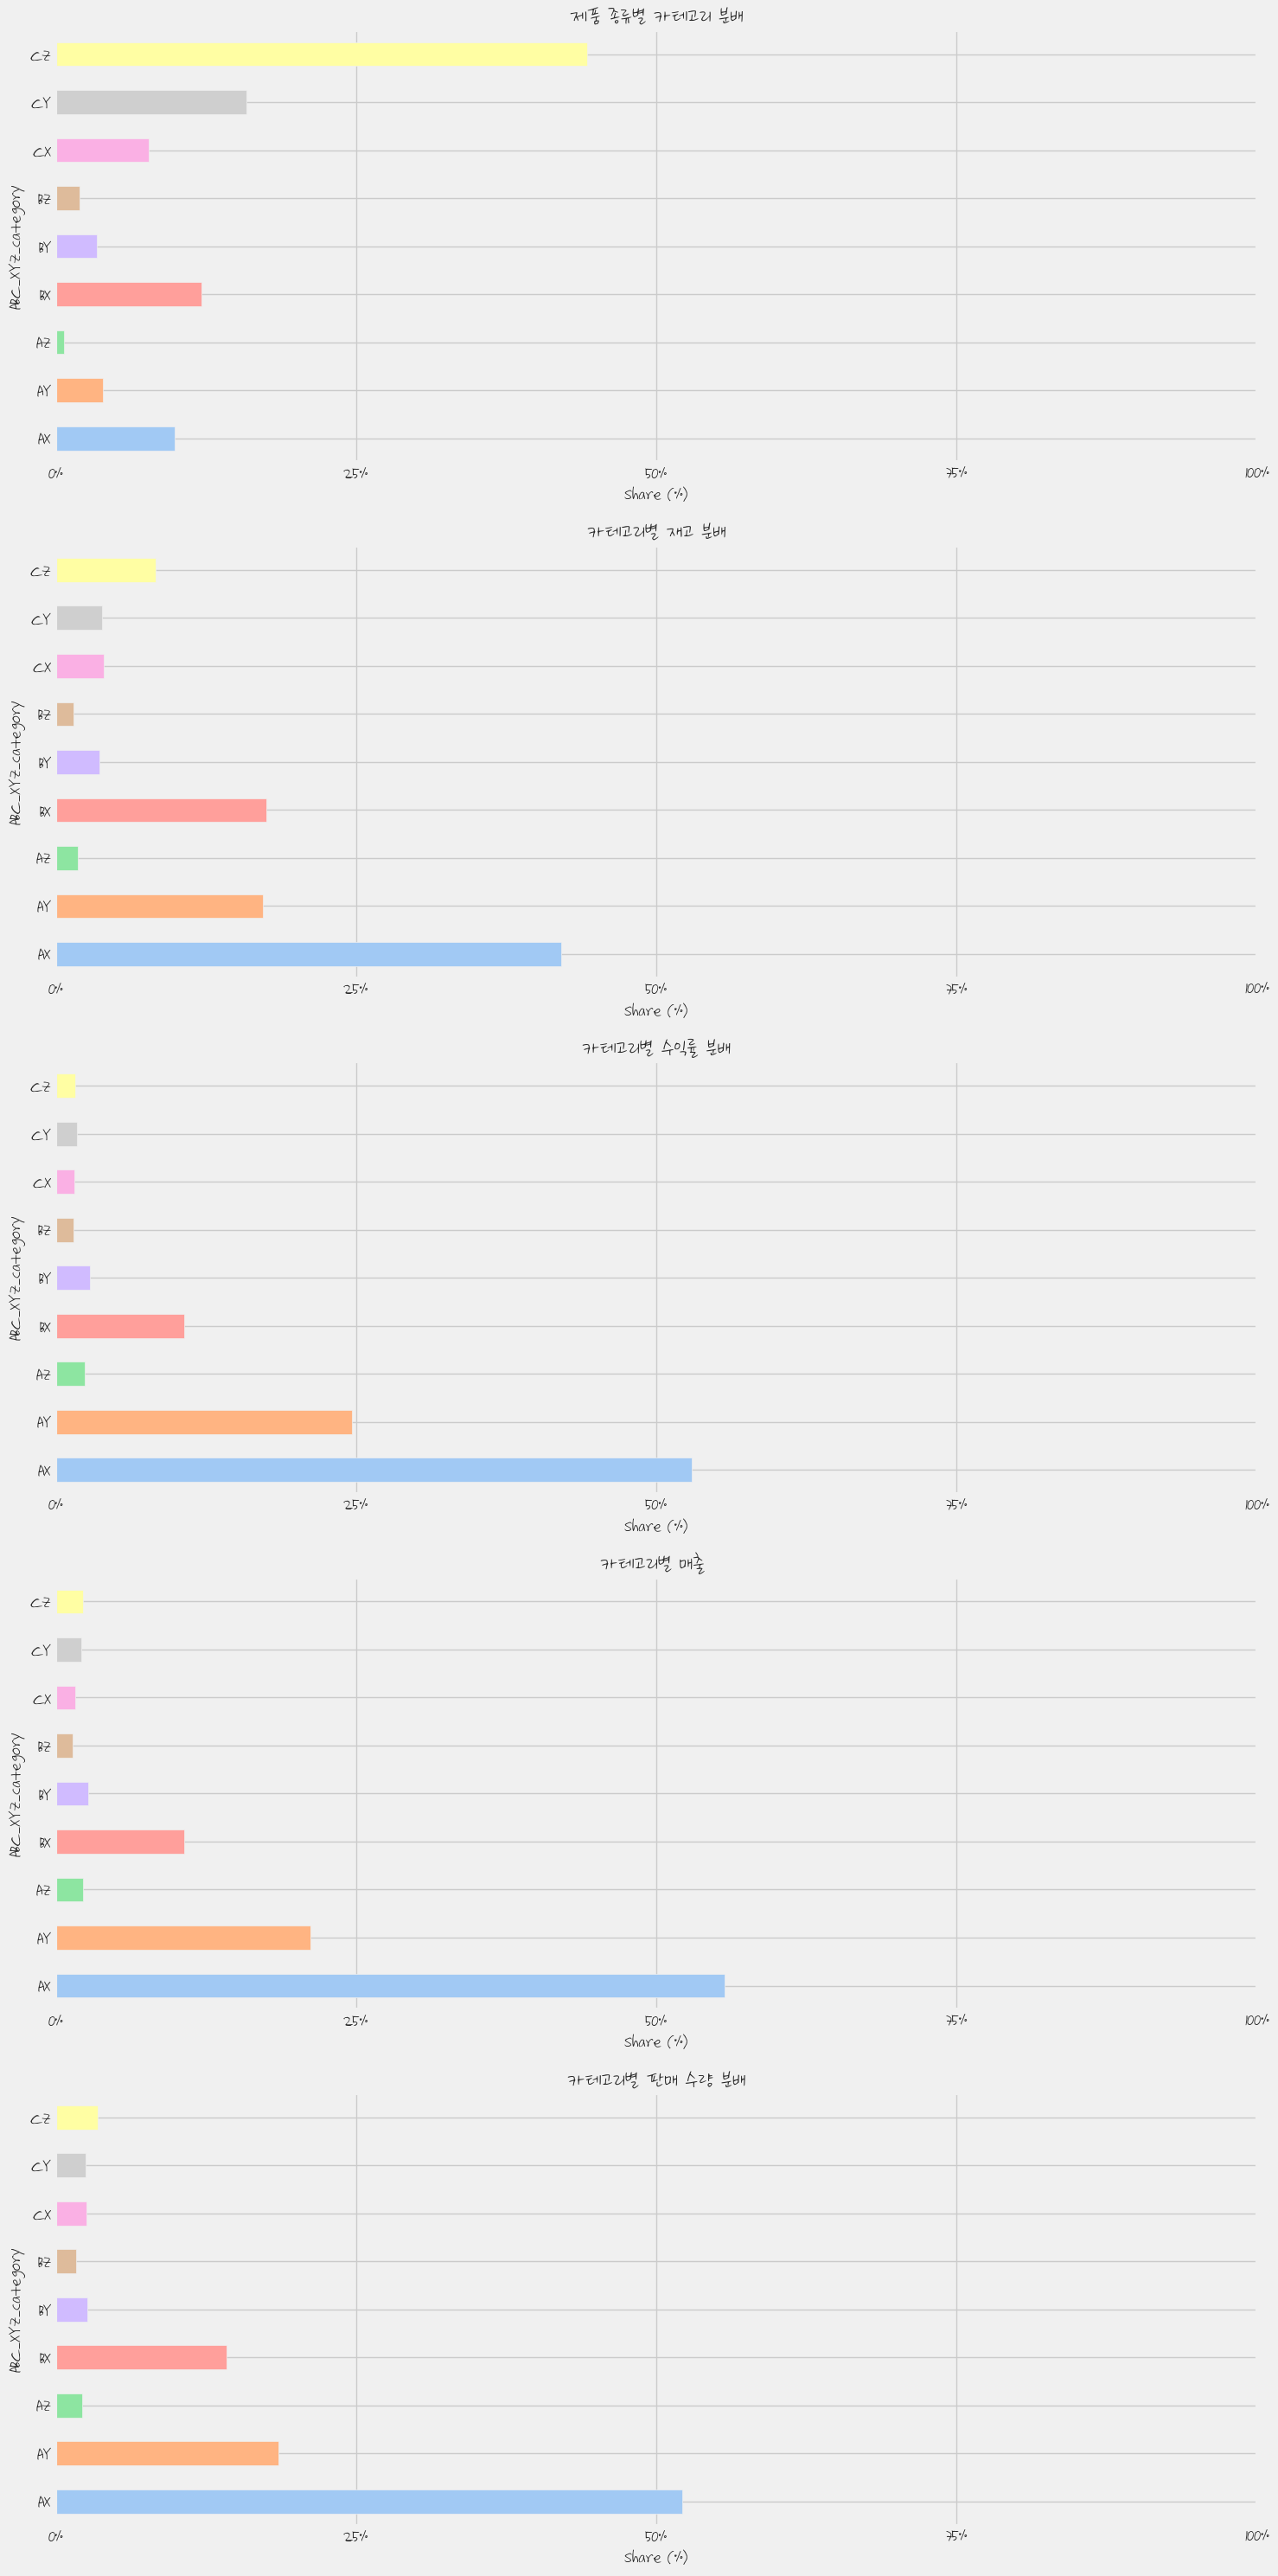

In [173]:
fig, ax = plt.subplots(5, 1, figsize=(15, 30))
colors = sns.color_palette('pastel')
labels = category_summary.index

titles = [
    "제품 종류별 카테고리 분배",
    "카테고리별 재고 분배",
    "카테고리별 수익률 분배",
    "카테고리별 매출 ",
    "카테고리별 판매 수량 분배"
]

shares = [
    category_summary['ItemShare'],
    category_summary['StockShare'],
    category_summary['ProfitShare'],
    category_summary['NetSalesShare'],
    category_summary['SalesQuantityShare']
]

# for ax, share, title in zip(ax, shares, titles):
#     ax.pie(share, labels=labels, colors=colors, autopct='%.0f%%', startangle=90,wedgeprops=dict(width=0.5))
#     ax.set_title(title, fontsize=12)

order = ['AX', 'AY', 'AZ', 'BX', 'BY', 'BZ', 'CX', 'CY', 'CZ']
share_ordered = share.reindex(order)
for ax, share_ordered, title in zip(ax,shares, titles):
    share_ordered.plot(kind='barh', ax=ax, color=sns.color_palette('pastel'))
    ax.set_title(title)
    ax.set_xlabel('Share (%)')
    ax.set_xlim(0, 1)  # since shares are in proportions (0–1)
    ax.set_xticks([0, 0.25, 0.5, 0.75, 1])
    ax.set_xticklabels(['0%', '25%', '50%', '75%', '100%'])

plt.tight_layout()

In [ ]:
category_summary

Text(0.5, 1.0, '카테고리별 비율')

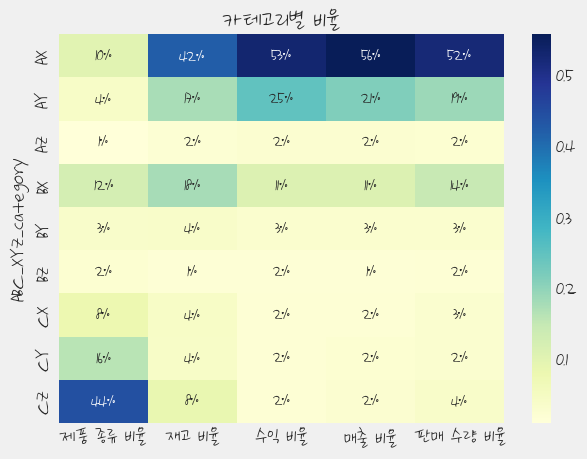

In [314]:
heatmap_data = category_summary[[
    'ItemShare', 'StockShare', 'ProfitShare', 'NetSalesShare', 'SalesQuantityShare']].rename(columns={
    'ItemShare': '제품 종류 비율',
    'StockShare': '재고 비율',
    'ProfitShare': '수익 비율',
    'NetSalesShare': '매출 비율',
    'SalesQuantityShare': '판매 수량 비율'
})


sns.heatmap(heatmap_data, annot=True, fmt=".0%", cmap="YlGnBu")

plt.title('카테고리별 비율')

In [275]:
vendors = sales.groupby('Brand')['VendorNo'].first().reset_index()

In [276]:
summary_table_vendor = summary_table.merge(vendors, on = 'Brand')

In [288]:
vendor_pivot = summary_table_vendor.pivot_table(index = 'VendorNo', columns = 'XYZ_Category', values = "Brand", aggfunc='nunique').fillna(0)

In [289]:
vendor_pivot['TTL'] = vendor_pivot['X'] + vendor_pivot['Y'] + vendor_pivot['Z']

In [301]:
(summary_table['XYZ_Category'] == 'Z').sum()

np.int64(5279)

In [291]:
vendor_pivot['Z_share'] = vendor_pivot['Z']/vendor_pivot['TTL']

In [302]:
vendor_pivot['TTL_share'] = vendor_pivot['Z']/(summary_table['XYZ_Category'] == 'Z').sum()

In [307]:
vendor_pivot['TTL_cum_share'] = vendor_pivot['TTL_share'].cumsum()

In [306]:
vendor_pivot=vendor_pivot.sort_values(by ='Z', ascending = False)

In [308]:
vendor_pivot

XYZ_Category,X,Y,Z,TTL,Z_share,TTL_share,TTL_cum_share
VendorNo,,,,,,,
4425,352.00,442.00,699.00,"1,493.00",0.47,0.13,0.13
10754,143.00,214.00,474.00,831.00,0.57,0.09,0.22
9165,224.00,191.00,465.00,880.00,0.53,0.09,0.31
9552,214.00,210.00,452.00,876.00,0.52,0.09,0.40
7153,93.00,86.00,245.00,424.00,0.58,0.05,0.44
2000,65.00,76.00,230.00,371.00,0.62,0.04,0.49
3252,235.00,108.00,167.00,510.00,0.33,0.03,0.52
1392,185.00,122.00,154.00,461.00,0.33,0.03,0.55
4692,28.00,38.00,148.00,214.00,0.69,0.03,0.57
